In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

## Getting different VIX data directly from Cboe

In [2]:
# First read information about VIX and similar index for emergin markets
start = "2007-05-10" # Thursday May 10, 2007

VIX = pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv')
VXEEM = pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VXEEM_History.csv')
VIX9D = pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX9D_History.csv')
Cboe = VIX.loc[:,['DATE','CLOSE']]
Cboe = pd.merge(Cboe, VIX9D.loc[:,['DATE','CLOSE']], on='DATE', how='outer')
Cboe = pd.merge(Cboe, VXEEM.loc[:,['DATE','CLOSE']], on='DATE', how='outer')
Cboe.columns = ['DATE','VIX','VIX9D','VXEEM']

# Now we are going to add another Cboe indices
for x in ['VVIX','OVX','GVZ']: # Volatility of VIX, Oil and Gold
    Cboe = pd.merge(Cboe,pd.read_csv('https://cdn.cboe.com/api/global/us_indices/daily_prices/' + x + '_History.csv'), 
                on='DATE', how='outer')
    
# Take the dates of interest
Cboe['DATE'] = pd.to_datetime(Cboe['DATE'])
Cboe.set_index('DATE', inplace=True)
Cboe.index.names = ['Date']
Cboe = Cboe.loc[start:, ]
# Fill the missing values with the past ones
Cboe.fillna(method='ffill', inplace=True)

Cboe

,VIX,VIX9D,VXEEM,VVIX,OVX,GVZ
Date,,,,,,
2007-05-10,13.60,NaN,NaN,83.58,NaN,NaN
2007-05-11,12.95,NaN,NaN,79.47,NaN,NaN
2007-05-14,13.96,NaN,NaN,82.02,NaN,NaN
2007-05-15,14.01,NaN,NaN,76.68,NaN,NaN
2007-05-16,13.50,NaN,NaN,70.26,NaN,NaN
...,...,...,...,...,...,...
2023-08-30,13.88,12.42,16.88,78.63,26.63,12.39
2023-08-31,13.57,11.79,16.99,80.80,26.56,11.78
2023-09-01,13.09,10.45,16.14,82.65,27.48,11.28


## Getting data from Yahoo Finance about some common indices

In [3]:
tickers = ['^GSPC','EEM','GC=F','CL=F'] # VIX, EEM, Gold and Oil

Indices_data = yf.download(tickers=tickers, start=start)['Close']
# Fill missing values with previous ones
Indices_data.fillna(method='ffill', inplace=True)

[*********************100%***********************]  4 of 4 completed


## Computing daily returns and their standard deviation

In [4]:
# Daily returns
Index_return_daily = np.log(Indices_data) - np.log(Indices_data).shift(1)
Index_return_daily

,CL=F,EEM,GC=F,^GSPC
Date,,,,
2007-05-10,NaN,NaN,NaN,NaN
2007-05-11,0.009019,0.025084,0.008235,0.009595
2007-05-14,0.001442,-0.009974,-0.003136,-0.001795
2007-05-15,0.011303,0.001202,0.006709,-0.001305
2007-05-16,-0.009863,0.014393,-0.019202,0.008590
...,...,...,...,...
2023-08-28,0.003376,0.009719,0.003552,0.006245
2023-08-29,0.013147,0.012646,0.009651,0.014404
2023-08-30,0.005774,-0.003273,0.004020,0.003826


In [5]:
# Rolling standard deviation on a 21 business day period, 30 days
Annualized_monthly_return = Index_return_daily.rolling(21).std() * 100 * np.sqrt(252)
Annualized_monthly_return

,CL=F,EEM,GC=F,^GSPC
Date,,,,
2007-05-10,NaN,NaN,NaN,NaN
2007-05-11,NaN,NaN,NaN,NaN
2007-05-14,NaN,NaN,NaN,NaN
2007-05-15,NaN,NaN,NaN,NaN
2007-05-16,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-08-28,23.109850,14.186751,8.452766,11.579133
2023-08-29,22.961604,15.165480,8.995745,12.809054
2023-08-30,22.983587,14.711440,7.449655,12.896994


# Comparing VIX vs Realized volatility

### VIX and S&P500

C:\Users\josel\anaconda3\lib\site-packages\pandas\core\indexing.py:862: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return getattr(section, self.name)[new_key]


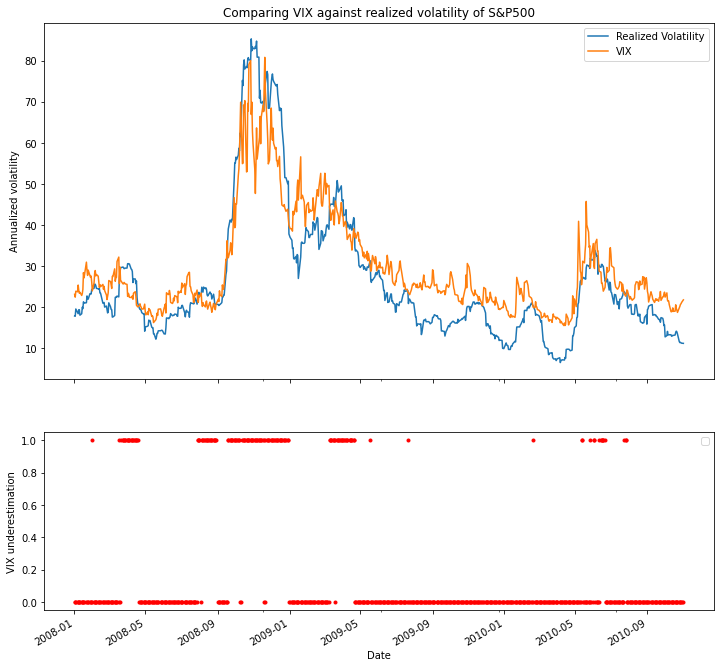

In [6]:
shared_index = Annualized_monthly_return.index.intersection(Cboe.index)
Difference_VIX_real_vol = pd.DataFrame(Annualized_monthly_return.loc[shared_index, '^GSPC'] - Cboe.loc[shared_index, 'VIX'])
Comparing_VIX_real_vol = (Difference_VIX_real_vol > 0) + 0

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return.loc['2008-01-01':'2010-11-01','^GSPC'].plot(ax=ax[0])
ax[0].set_title('Comparing VIX against realized volatility of S&P500')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe.loc['2008-01-01':'2010-11-01','VIX'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','VIX'])

Comparing_VIX_real_vol.loc['2008-01-01':'2010-11-01', :].plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('VIX underestimation')

plt.savefig('Comparing_VIX_vs_real_vol_2008-2011.png')

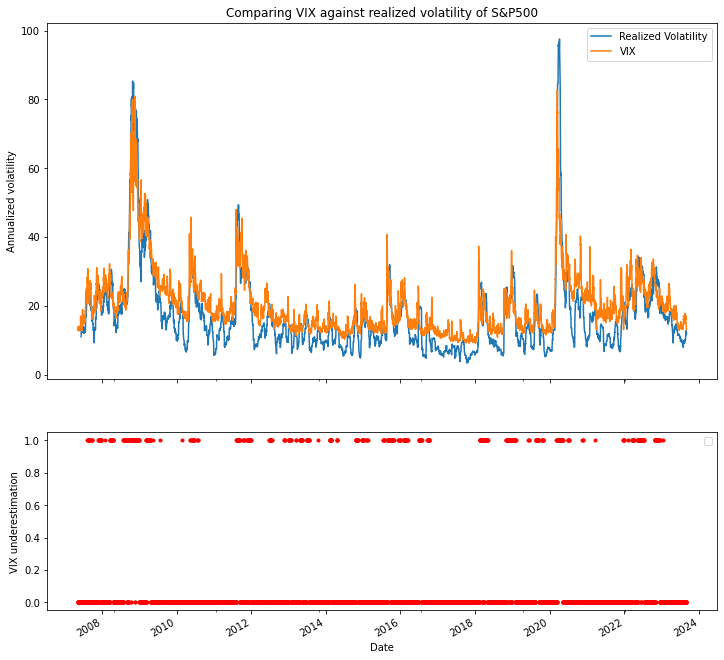

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return['^GSPC'].plot(ax=ax[0])
ax[0].set_title('Comparing VIX against realized volatility of S&P500')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe['VIX'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','VIX'])

Comparing_VIX_real_vol.plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('VIX underestimation')

plt.savefig('Comparing_VIX_vs_real_vol_2008-2023.png')

C:\Users\josel\anaconda3\lib\site-packages\pandas\core\indexing.py:862: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return getattr(section, self.name)[new_key]
C:\Users\josel\anaconda3\lib\site-packages\pandas\core\indexing.py:1109: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return self._getitem_tuple_same_dim(tup)


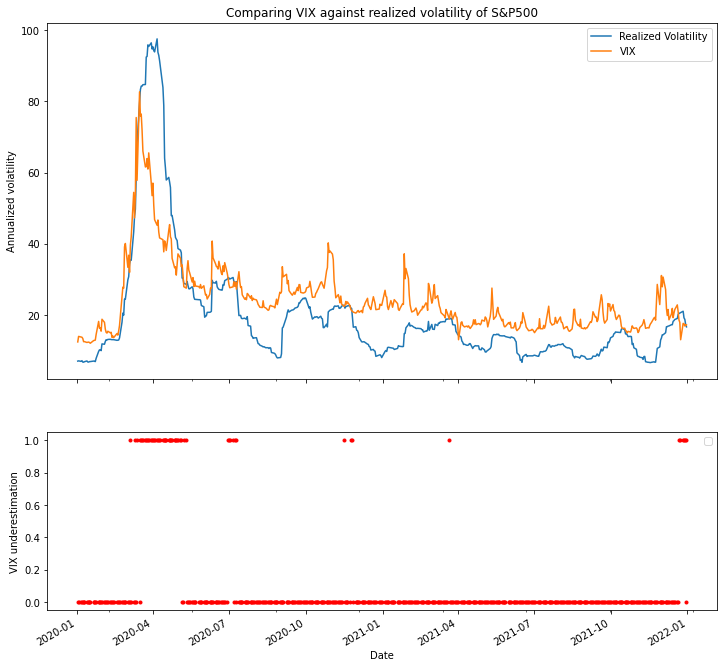

In [8]:
shared_index = set(Annualized_monthly_return.index) & set(Cboe.index)
Difference_VIX_real_vol = pd.DataFrame(Annualized_monthly_return.loc[shared_index, '^GSPC'] - Cboe.loc[shared_index, 'VIX'])
Comparing_VIX_real_vol = (Difference_VIX_real_vol > 0) + 0

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return.loc['2020-01-01':'2022-01-01','^GSPC'].plot(ax=ax[0])
ax[0].set_title('Comparing VIX against realized volatility of S&P500')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe.loc['2020-01-01':'2022-01-01','VIX'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','VIX'])

Comparing_VIX_real_vol.loc['2020-01-01':'2022-01-01', :].plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('VIX underestimation')

plt.savefig('Comparing_VIX_vs_real_vol_2020-2022.png')

In [9]:
print(Comparing_VIX_real_vol.sum(), Comparing_VIX_real_vol.shape[0])
print(Comparing_VIX_real_vol.sum() / Comparing_VIX_real_vol.shape[0])

print(Difference_VIX_real_vol[Comparing_VIX_real_vol == 1].mean(skipna=True) * 100)
print(Difference_VIX_real_vol[Comparing_VIX_real_vol == 0].mean(skipna=True) * 100)

0    689
dtype: int64 4108
0    0.167722
dtype: float64
0    511.434459
dtype: float64
0   -515.508247
dtype: float64


### VXEEM and EEM

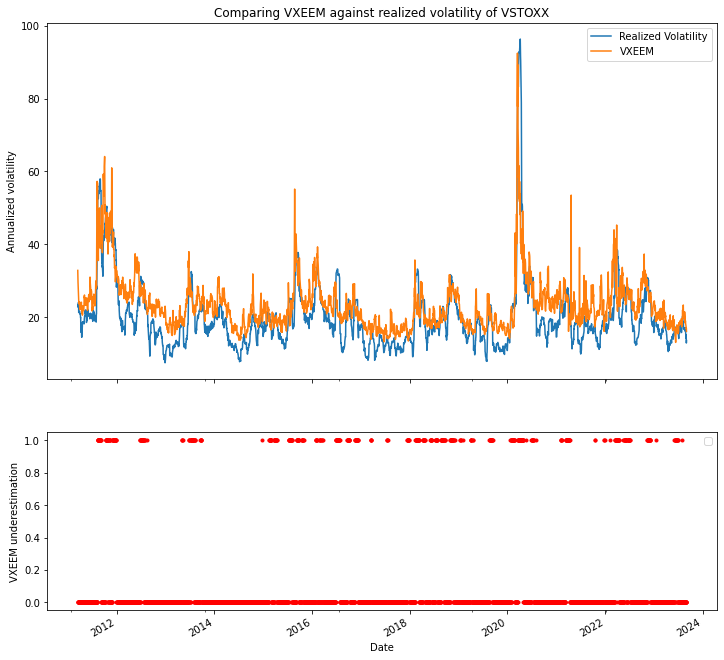

In [10]:
first_VXEEM = max(Indices_data['EEM'].first_valid_index(), Cboe['VXEEM'].first_valid_index())
Difference_VXEEM_real_vol = pd.DataFrame(Annualized_monthly_return.loc[shared_index, 'EEM'] - Cboe.loc[shared_index, 'VXEEM'])
Comparing_VXEEM_real_vol = (Difference_VXEEM_real_vol > 0) + 0
# It looks things get mixed while comparing
Comparing_VXEEM_real_vol.sort_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return.loc[first_VXEEM:,'EEM'].plot(ax=ax[0])
ax[0].set_title('Comparing VXEEM against realized volatility of VSTOXX')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe.loc[first_VXEEM:,'VXEEM'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','VXEEM'])

Comparing_VXEEM_real_vol.loc[first_VXEEM:, :].plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('VXEEM underestimation')

plt.savefig('Comparing_VXEEM_vs_real_vol.png')

In [11]:
print(Comparing_VXEEM_real_vol.sum(), Comparing_VXEEM_real_vol.shape[0])
print(Comparing_VXEEM_real_vol.sum() / Comparing_VXEEM_real_vol.shape[0])

print(Difference_VXEEM_real_vol[Comparing_VXEEM_real_vol == 1].mean(skipna=True) * 100)
print(Difference_VXEEM_real_vol[Comparing_VXEEM_real_vol == 0].mean(skipna=True) * 100)

0    534
dtype: int64 4108
0    0.12999
dtype: float64
0    454.38751
dtype: float64
0   -517.126652
dtype: float64


### GVZ and Gold

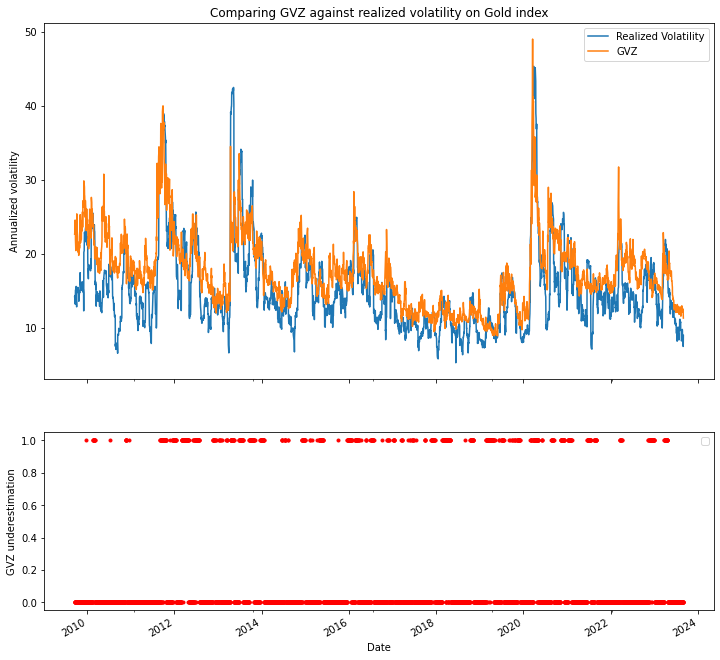

In [12]:
first_GVZ = max(Indices_data['GC=F'].first_valid_index(), Cboe['GVZ'].first_valid_index())
Difference_GVZ_real_vol = pd.DataFrame(Annualized_monthly_return.loc[shared_index, 'GC=F'] - Cboe.loc[shared_index, 'GVZ'])
Comparing_GVZ_real_vol = (Difference_GVZ_real_vol > 0) + 0
# It looks things get mixed while comparing
Comparing_GVZ_real_vol.sort_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return.loc[first_GVZ:,'GC=F'].plot(ax=ax[0])
ax[0].set_title('Comparing GVZ against realized volatility on Gold index')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe.loc[first_GVZ:,'GVZ'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','GVZ'])

Comparing_GVZ_real_vol.loc[first_GVZ:, :].plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('GVZ underestimation')

plt.savefig('Comparing_GVZ_vs_real_vol.png')

In [13]:
print(Comparing_GVZ_real_vol.sum(), Comparing_GVZ_real_vol.shape[0])
print(Comparing_GVZ_real_vol.sum() / Comparing_GVZ_real_vol.shape[0])

print(Difference_GVZ_real_vol[Comparing_GVZ_real_vol == 1].mean(skipna=True) * 100)
print(Difference_GVZ_real_vol[Comparing_GVZ_real_vol == 0].mean(skipna=True) * 100)

0    747
dtype: int64 4108
0    0.18184
dtype: float64
0    256.393002
dtype: float64
0   -364.860071
dtype: float64


### OVX and Oil

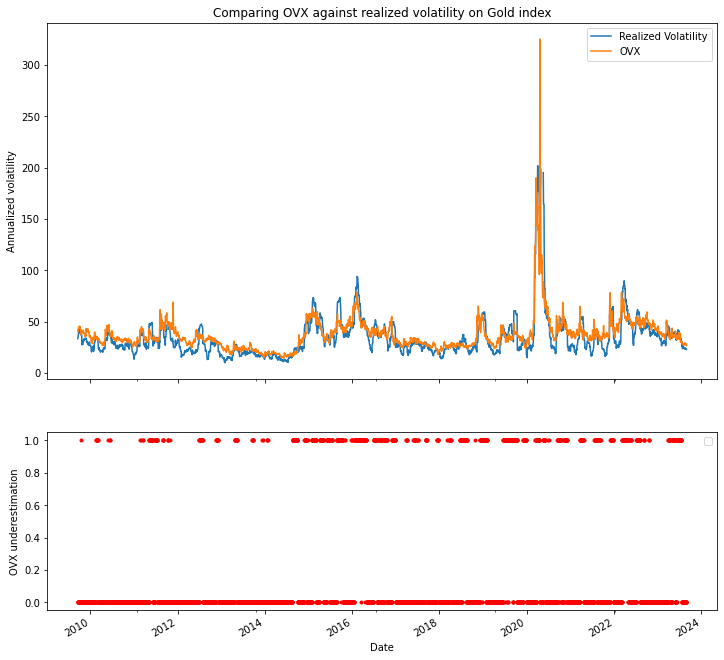

In [14]:
first_OVX = max(Indices_data['CL=F'].first_valid_index(), Cboe['OVX'].first_valid_index())
Difference_OVX_real_vol = pd.DataFrame(Annualized_monthly_return.loc[shared_index, 'CL=F'] - Cboe.loc[shared_index, 'OVX'])
Comparing_OVX_real_vol = (Difference_OVX_real_vol > 0) + 0
# It looks things get mixed while comparing
Comparing_OVX_real_vol.sort_index(inplace=True)

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
Annualized_monthly_return.loc[first_OVX:,'CL=F'].plot(ax=ax[0])
ax[0].set_title('Comparing OVX against realized volatility on Gold index')
ax[0].set_ylabel('Annualized volatility')
ax[0].set_xlabel("Date")

Cboe.loc[first_OVX:,'OVX'].plot(ax=ax[0])
ax[0].legend(['Realized Volatility','OVX'])

Comparing_OVX_real_vol.loc[first_OVX:, :].plot(style='.', color='r', ax=ax[1])
ax[1].legend([])
ax[1].set_ylabel('OVX underestimation')

plt.savefig('Comparing_OVX_vs_real_vol.png')

In [15]:
print(Comparing_OVX_real_vol.sum(), Comparing_OVX_real_vol.shape[0])
print(Comparing_OVX_real_vol.sum() / Comparing_OVX_real_vol.shape[0])

print(Difference_OVX_real_vol[Comparing_OVX_real_vol == 1].mean(skipna=True) * 100)
print(Difference_OVX_real_vol[Comparing_OVX_real_vol == 0].mean(skipna=True) * 100)

0    865
dtype: int64 4108
0    0.210565
dtype: float64
0    808.5563
dtype: float64
0   -701.839566
dtype: float64
